<a href="https://colab.research.google.com/github/Cams75018/Velib_predictions/blob/master/LSTM_multistep_min_par_min_boucle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import datetime

### **Parametres**

In [0]:
import timeit
start_time = timeit.default_timer()

In [0]:
heurefin=9   # heure de test de la journée et donc cut du dataset au dernier jour à cette heure
minute=15
heuredebut=datetime.datetime(2020,1,28,23,30,0)
nsteps_in, nsteps_out = 30, 30
nsteps_in2=60
nsteps_in3=90
epok =5

In [4]:

df=pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (14800, 5)


,Unnamed: 0,availiable_docks,date,weekday,hour
0,0,8,2020-01-15 10:17:00,Wednesday,10
1,1,8,2020-01-15 10:18:00,Wednesday,10
2,2,7,2020-01-15 10:19:00,Wednesday,10
3,3,8,2020-01-15 10:20:00,Wednesday,10
4,4,8,2020-01-15 10:21:00,Wednesday,10


In [0]:
df['datedate'] = pd.to_datetime(df['date'])


In [6]:
# on repère l'index de la dernière minutes à prédire
lastindex=df[df.datedate==heuredebut].index.max()
dfx=df.iloc[0:lastindex+1,:]
dfx.tail()

,Unnamed: 0,availiable_docks,date,weekday,hour,datedate
13346,13346,19,2020-01-28 23:26:00,Tuesday,23,2020-01-28 23:26:00
13347,13347,19,2020-01-28 23:27:00,Tuesday,23,2020-01-28 23:27:00
13348,13348,19,2020-01-28 23:28:00,Tuesday,23,2020-01-28 23:28:00
13349,13349,19,2020-01-28 23:29:00,Tuesday,23,2020-01-28 23:29:00
13350,13350,19,2020-01-28 23:30:00,Tuesday,23,2020-01-28 23:30:00


In [0]:
#dfx=df[(df.hour==heurefin-1) | (df.hour== heurefin)]
#lastindex=dfx.index.max()
for i in range(lastindex,lastindex +1+ nsteps_out,1):
  dfx.loc[i]=df.iloc[i,:]
dfx.reset_index(inplace=True)


In [0]:
#for ind in range(len(df)-1, -int(len(df)/10)  , -1):
#   if df.hour[ind]==heurefin:
#     print(df.date[ind],ind, len(df))
#     findf=ind
#     break

In [9]:
df2=dfx.loc[:dfx.index.max(),['date','availiable_docks']]
#df3.sort_values('datenew', inplace=True, ascending=True)
#df3 = df3.reset_index(drop=True)
print('Number of rows and columns:',dfx.shape)
print(df2.date.min())
print(df2.date.max())
df2.columns=["datenew","TOTALFD"]


Number of rows and columns: (13381, 7)
2020-01-15 10:17:00
2020-01-29 00:00:00


In [10]:
df3=df2.loc[:len(df2)-1-nsteps_out,["datenew","TOTALFD"]]
df3.tail()

,datenew,TOTALFD
13346,2020-01-28 23:26:00,19
13347,2020-01-28 23:27:00,19
13348,2020-01-28 23:28:00,19
13349,2020-01-28 23:29:00,19
13350,2020-01-28 23:30:00,19


In [11]:
print('Number of rows and columns after removing missing values:', df3.shape)
print('The time series starts from: ', df3.datenew.min())
print('The time series ends on: ', df3.datenew.max())

Number of rows and columns after removing missing values: (13351, 2)
The time series starts from:  2020-01-15 10:17:00
The time series ends on:  2020-01-28 23:30:00


### First Time series plot

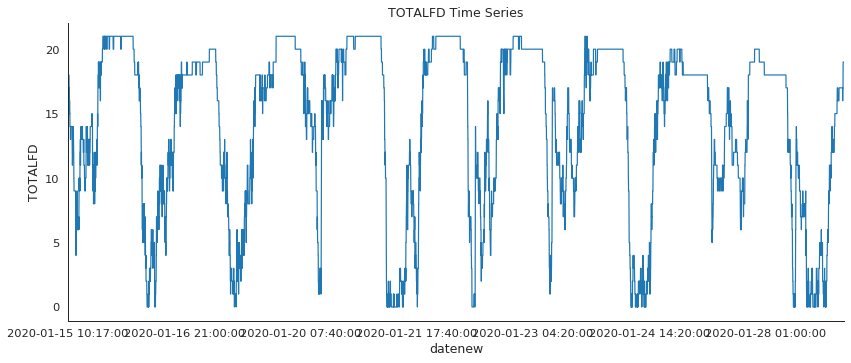

In [12]:
df4=df3.loc[:,['datenew','TOTALFD']]
df5=df3.loc[:,['datenew','TOTALFD']]
df4.set_index('datenew',inplace=True)
df4.plot(figsize=(12,5))
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('TOTALFD Time Series')
sns.despine(top=True)
plt.show();

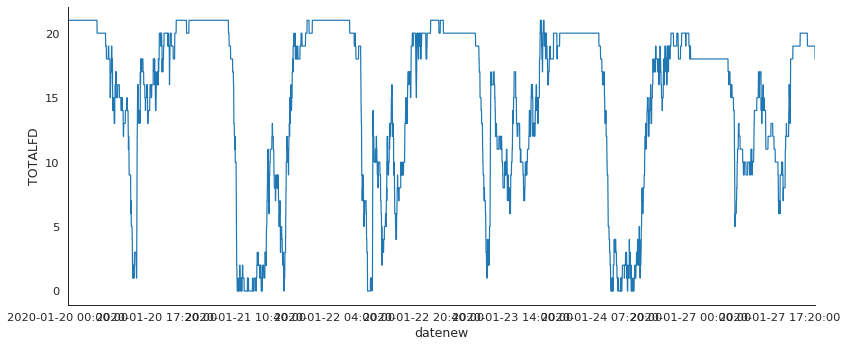

In [13]:
df5=df4[(df4.index>='2020-01-20') & (df4.index<'2020-01-28')]
df5.plot(figsize=(12,5));
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### TOTALFD Distribution

,count,mean,std,min,25%,50%,75%,max
TOTALFD,13351.0000,14.2717,6.5103,0.0000,10.0000,17.0000,20.0000,21.0000


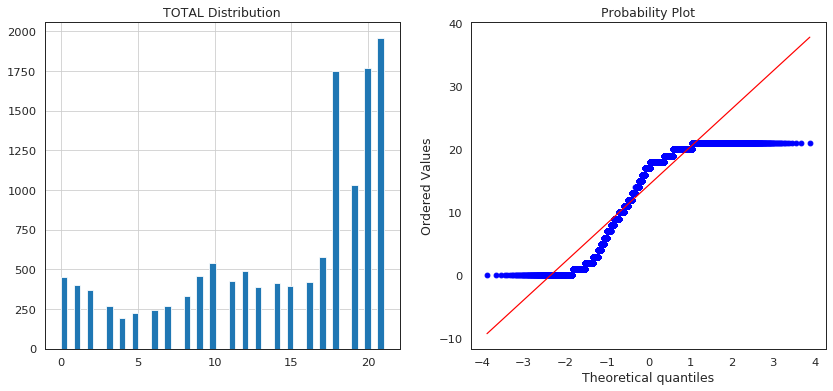

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df3['TOTALFD'].hist(bins=50)
plt.title('TOTAL Distribution')

plt.subplot(1,2,2)
stats.probplot(df3['TOTALFD'], plot=plt);
df3.describe().T

Normal probability plot also shows the data set is far from normally distributed.

**MULTI-STEP LSTM**

In [0]:
from sklearn.preprocessing import MinMaxScaler

LSTM multi-step encoder -decoder step_in 96, setp out 5 couche 100  normalisé

model 1

In [16]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
raw_seq = df3.TOTALFD.to_numpy()
#normalisation
raw_seq_scaled = scaler.fit_transform(raw_seq.reshape(-1,1))
#raw_seq_scaled = scaled_values.reshape(1,len(raw_seq_scaled)  )
# choose a number of time steps

n_steps_in, n_steps_out = nsteps_in, nsteps_out

X, y = split_sequence(raw_seq_scaled, n_steps_in, n_steps_out)
X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction
#x_input = array(raw_seq[-n_steps_in:])
# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(X_input_scal, verbose=0)
yhat=scaler.inverse_transform(yhat.reshape(yhat.shape[0],yhat.shape[1]))
elapsed = timeit.default_timer() - start_time
print(yhat)

Using TensorFlow backend.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





13292/13292 [==============================] - 50s 4ms/step - loss: 0.0500
Epoch 2/5
13292/13292 [==============================] - 40s 3ms/step - loss: 0.0309
Epoch 3/5
13292/13292 [==============================] - 39s 3ms/step - loss: 0.0299
Epoch 4/5
13292/13292 [==============================] - 40s 3ms/step - loss: 0.0292
Epoch 5/5
13292/13292 [==============================] - 40s 3ms/step - loss: 0.0288
[[18.526617 19.126904 19.33997  19.365309 19.384552 19.391678 19.386711
  19.379108 19.37119  19.363375 19.3563   19.35022  19.345188 19.341135
  19.337929 19.335436 19.333517 19.332058 19.33096  19.330137 19.329527
  19.32908  19.328754 19.32852  19.328356 19.32824  19.328157 19.328106
  19.32807  19.328045]]


**Visualisation predictions**

In [17]:


dfres=df2.tail(n_steps_out*3)
dfres["pred"]=0.0
dfres = dfres.reset_index()
#lastindex=dfres.tail(1).index.start
yhatdata=pd.DataFrame(yhat.reshape(n_steps_out,1))
for ind in range(len(dfres)-1, -len(yhatdata) + len(dfres)-1 , -1):
   dfres["pred"][ind]=yhatdata.iloc[ind-len(dfres)]
dfres.tail(n_steps_out)



,index,datenew,TOTALFD,pred
60,13351,2020-01-28 23:31:00,19,18.5266
61,13352,2020-01-28 23:32:00,19,19.1269
62,13353,2020-01-28 23:33:00,19,19.3400
63,13354,2020-01-28 23:34:00,19,19.3653
64,13355,2020-01-28 23:35:00,19,19.3846
65,13356,2020-01-28 23:36:00,19,19.3917
66,13357,2020-01-28 23:37:00,19,19.3867
67,13358,2020-01-28 23:38:00,19,19.3791
68,13359,2020-01-28 23:39:00,19,19.3712
69,13360,2020-01-28 23:40:00,19,19.3634


In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedf=dfres.tail(n_steps_out)
heurefin=heuredebut+datetime.timedelta(minutes=nsteps_out)
print("RMSE ",measure_rmse(msedf.TOTALFD,msedf.pred))
print("RMSE prédictions arrondies ", measure_rmse(msedf.TOTALFD,round(msedf.pred)))
print("nb epoch", epok)
print("nb stepIN", nsteps_in)
print("nb stepOUT", nsteps_out)
print("prédiction de ",heuredebut.hour,"h",heuredebut.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
print("temps d'execution " , int(elapsed/60), "min", int((round(elapsed/60,2,)-(int(elapsed/60)))*60), "s")

RMSE  0.3456637958029042
RMSE prédictions arrondies  0.0
nb epoch 5
nb stepIN 30
nb stepOUT 30
prédiction de  23 h 30  à  0 h 0 min
temps d'execution  3 min 33 s


In [19]:
heurefin

datetime.datetime(2020, 1, 29, 0, 0)

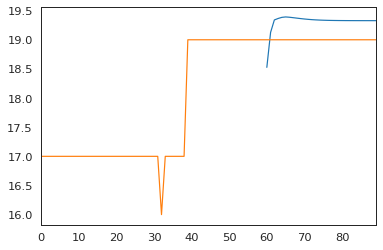

In [20]:

import matplotlib.pyplot as plt
dfres['pred'].tail(n_steps_out).plot()
dfres['TOTALFD'].plot()





model 2

In [21]:
start_time2 = timeit.default_timer()

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

n_steps_in, n_steps_out = nsteps_in2, nsteps_out

X, y = split_sequence(raw_seq_scaled, n_steps_in, n_steps_out)
X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model2.add(RepeatVector(n_steps_out))

model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(1)))
model2.compile(optimizer='adam', loss='mse')

# fit model
model2.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction

# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat2 = model2.predict(X_input_scal, verbose=0)
yhat2=scaler.inverse_transform(yhat2.reshape(yhat2.shape[0],yhat2.shape[1]))
elapsed2 = timeit.default_timer() - start_time2
print(yhat2)

Epoch 1/5
13262/13262 [==============================] - 61s 5ms/step - loss: 0.0492
Epoch 2/5
13262/13262 [==============================] - 59s 4ms/step - loss: 0.0312
Epoch 3/5
13262/13262 [==============================] - 59s 4ms/step - loss: 0.0297
Epoch 4/5
13262/13262 [==============================] - 60s 5ms/step - loss: 0.0292
Epoch 5/5
13262/13262 [==============================] - 59s 4ms/step - loss: 0.0291
[[19.2845   19.288752 19.220833 19.19227  19.180964 19.183823 19.188646
  19.184809 19.174892 19.161371 19.14666  19.132414 19.11961  19.108677
  19.099705 19.09256  19.087023 19.082825 19.079714 19.077456 19.075848
  19.074734 19.073982 19.073492 19.073189 19.073013 19.072926 19.072897
  19.0729   19.07293 ]]


**Visualisation predictions**

In [22]:


dfres2=df2.tail(n_steps_out*3)
dfres2["pred"]=0.0
dfres2 = dfres2.reset_index()
#lastindex=dfres.tail(1).index.start
yhatdata2=pd.DataFrame(yhat2.reshape(n_steps_out,1))
for ind in range(len(dfres2)-1, -len(yhatdata2) + len(dfres2)-1 , -1):
   dfres2["pred"][ind]=yhatdata2.iloc[ind-len(dfres2)]
dfres2.tail(n_steps_out)



,index,datenew,TOTALFD,pred
60,13351,2020-01-28 23:31:00,19,19.2845
61,13352,2020-01-28 23:32:00,19,19.2888
62,13353,2020-01-28 23:33:00,19,19.2208
63,13354,2020-01-28 23:34:00,19,19.1923
64,13355,2020-01-28 23:35:00,19,19.1810
65,13356,2020-01-28 23:36:00,19,19.1838
66,13357,2020-01-28 23:37:00,19,19.1886
67,13358,2020-01-28 23:38:00,19,19.1848
68,13359,2020-01-28 23:39:00,19,19.1749
69,13360,2020-01-28 23:40:00,19,19.1614


In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedf2=dfres2.tail(n_steps_out)
heurefin=heuredebut+datetime.timedelta(minutes=nsteps_out)
print("RMSE 2",measure_rmse(msedf2.TOTALFD,msedf2.pred))
print("RMSE 2 prédictions arrondies ", measure_rmse(msedf2.TOTALFD,round(msedf2.pred)))
print("nb epoch", epok)
print("nb stepIN", nsteps_in2)
print("nb stepOUT", nsteps_out)
print("prédiction de ",heuredebut.hour,"h",heuredebut.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
print("temps d'execution " , int(elapsed2/60), "min", int((round(elapsed2/60,2,)-(int(elapsed2/60)))*60), "s")

RMSE 2 0.14231198480239993
RMSE 2 prédictions arrondies  0.0
nb epoch 5
nb stepIN 60
nb stepOUT 30
prédiction de  23 h 30  à  0 h 0 min
temps d'execution  4 min 59 s


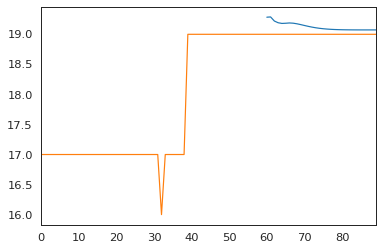

In [24]:

import matplotlib.pyplot as plt
dfres2['pred'].tail(n_steps_out).plot()
dfres2['TOTALFD'].plot()


# code you want to evaluate
#elapsed = timeit.default_timer() - start_time


model 3

In [25]:
start_time3 = timeit.default_timer()

from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

n_steps_in, n_steps_out = nsteps_in3, nsteps_out

X, y = split_sequence(raw_seq_scaled, n_steps_in, n_steps_out)
X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model3 = Sequential()
model3.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model3.add(RepeatVector(n_steps_out))

model3.add(LSTM(100, activation='relu', return_sequences=True))
model3.add(TimeDistributed(Dense(1)))
model3.compile(optimizer='adam', loss='mse')

# fit model
model3.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction

# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat3 = model3.predict(X_input_scal, verbose=0)
yhat3=scaler.inverse_transform(yhat3.reshape(yhat3.shape[0],yhat3.shape[1]))
elapsed3 = timeit.default_timer() - start_time3
print(yhat3)

Epoch 1/5
13232/13232 [==============================] - 80s 6ms/step - loss: 0.1162
Epoch 2/5
13232/13232 [==============================] - 80s 6ms/step - loss: 0.0308
Epoch 3/5
13232/13232 [==============================] - 78s 6ms/step - loss: 0.0300
Epoch 4/5
13232/13232 [==============================] - 78s 6ms/step - loss: 0.0296
Epoch 5/5
13232/13232 [==============================] - 79s 6ms/step - loss: 0.0288
[[19.139597 18.732557 18.661718 18.69199  18.697807 18.66678  18.627821
  18.596205 18.571886 18.55257  18.536276 18.521946 18.509178 18.49788
  18.48813  18.47984  18.472925 18.467272 18.462727 18.459127 18.456314
  18.454145 18.45249  18.451239 18.450302 18.449604 18.449091 18.448717
  18.448444 18.448246]]


**Visualisation predictions**

In [26]:


dfres3=df2.tail(n_steps_out*3)
dfres3["pred"]=0.0
dfres3 = dfres3.reset_index()
#lastindex=dfres.tail(1).index.start
yhatdata3=pd.DataFrame(yhat3.reshape(n_steps_out,1))
for ind in range(len(dfres3)-1, -len(yhatdata3) + len(dfres3)-1 , -1):
   dfres3["pred"][ind]=yhatdata3.iloc[ind-len(dfres3)]
dfres3.tail(n_steps_out)



,index,datenew,TOTALFD,pred
60,13351,2020-01-28 23:31:00,19,19.1396
61,13352,2020-01-28 23:32:00,19,18.7326
62,13353,2020-01-28 23:33:00,19,18.6617
63,13354,2020-01-28 23:34:00,19,18.6920
64,13355,2020-01-28 23:35:00,19,18.6978
65,13356,2020-01-28 23:36:00,19,18.6668
66,13357,2020-01-28 23:37:00,19,18.6278
67,13358,2020-01-28 23:38:00,19,18.5962
68,13359,2020-01-28 23:39:00,19,18.5719
69,13360,2020-01-28 23:40:00,19,18.5526


In [27]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedf3=dfres3.tail(n_steps_out)
heurefin=heuredebut+datetime.timedelta(minutes=nsteps_out)
print("RMSE 3 ",measure_rmse(msedf3.TOTALFD,msedf2.pred))
print("RMSE 3 prédictions arrondies ", measure_rmse(msedf3.TOTALFD,round(msedf3.pred)))
print("nb epoch", epok)
print("nb stepIN", nsteps_in3)
print("nb stepOUT", nsteps_out)
print("prédiction de ",heuredebut.hour,"h",heuredebut.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
print("temps d'execution " , int(elapsed3/60), "min", int((round(elapsed3/60,2,)-(int(elapsed3/60)))*60), "s")

RMSE 3  0.14231198480239993
RMSE 3 prédictions arrondies  0.752772652709081
nb epoch 5
nb stepIN 90
nb stepOUT 30
prédiction de  23 h 30  à  0 h 0 min
temps d'execution  6 min 37 s


In [28]:
raw_seq[-n_steps_in:]

array([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 17, 17, 17, 17, 17,
       17, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19])

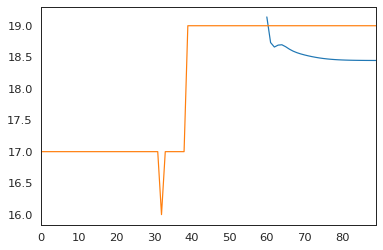

In [29]:

import matplotlib.pyplot as plt
dfres3['pred'].tail(n_steps_out).plot()
dfres3['TOTALFD'].plot()


# code you want to evaluate
#elapsed = timeit.default_timer() - start_time


In [33]:
#Predictions sur modèle entrainé
# 1 normalisation
# 2 predictions
# 3 dé-normalisation

heurefin=9   # heure de test de la journée et donc cut du dataset au dernier jour à cette heure
minute=15
heuredebutt=datetime.datetime(2020,1,29,8,30,0)
nsteps_in, nsteps_out = 90, 30
nsteps_in2= 60
nsteps_in3= 90
epok =2

n_steps_in=nsteps_in3

lastindexx=df[df.datedate==heuredebutt].index.max()
dfxx=df.iloc[0:lastindexx+1,:]
dfxx.tail()

for i in range(lastindexx,lastindexx +1+ nsteps_out,1):
  dfxx.loc[i]=df.iloc[i,:]
dfxx.reset_index(inplace=True)

df22=dfxx.loc[:dfxx.index.max(),['date','availiable_docks']]
#df3.sort_values('datenew', inplace=True, ascending=True)
#df3 = df3.reset_index(drop=True)
print('Number of rows and columns:',dfxx.shape)
print(df22.date.min())
print(df22.date.max())
df22.columns=["datenew","TOTALFD"]

df33=df22.loc[:len(df22)-1-nsteps_out,["datenew","TOTALFD"]]
df33.tail()

raw_seq = df33.TOTALFD.to_numpy()
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhatt = model3.predict(X_input_scal, verbose=0)
yhatt=scaler.inverse_transform(yhatt.reshape(yhatt.shape[0],yhatt.shape[1]))


dfress=df22.tail(n_steps_out*3)
dfress["pred"]=0.0
dfress = dfress.reset_index()
#lastindex=dfres.tail(1).index.start
yhat22=pd.DataFrame(yhatt.reshape(n_steps_out,1))
for ind in range(len(dfress)-1, -len(yhat22) + len(dfress)-1 , -1):
   dfress["pred"][ind]=yhat22.iloc[ind-len(dfress)]


def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedff=dfress.tail(n_steps_out)
heurefin=heuredebutt+datetime.timedelta(minutes=nsteps_out)
print("RMSE 3 ",measure_rmse(msedff.TOTALFD,msedff.pred))
print("RMSE 3 prédictions arrondies ", measure_rmse(msedff.TOTALFD,round(msedff.pred)))
print("nb epoch", epok)
print("nb stepIN", n_steps_in)
print("nb stepOUT", nsteps_out)
print("prédiction de ",heuredebutt.hour,"h",heuredebutt.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
print("temps d'execution " , int(elapsed3/60), "min", int((round(elapsed3/60,2,)-(int(elapsed3/60)))*60), "s")

dfress.tail(n_steps_out)

Number of rows and columns: (13881, 7)
2020-01-15 10:17:00
2020-01-29 09:00:00
RMSE 3  1.2212331835755375
RMSE 3 prédictions arrondies  1.2649110640673518
nb epoch 2
nb stepIN 90
nb stepOUT 30
prédiction de  8 h 30  à  9 h 0 min
temps d'execution  6 min 37 s


,index,datenew,TOTALFD,pred
60,13851,2020-01-29 08:31:00,11,10.8624
61,13852,2020-01-29 08:32:00,10,10.4421
62,13853,2020-01-29 08:33:00,10,9.9896
63,13854,2020-01-29 08:34:00,10,9.6872
64,13855,2020-01-29 08:35:00,10,9.4362
65,13856,2020-01-29 08:36:00,10,9.2090
66,13857,2020-01-29 08:37:00,10,9.0051
67,13858,2020-01-29 08:38:00,10,8.8231
68,13859,2020-01-29 08:39:00,10,8.6773
69,13860,2020-01-29 08:40:00,10,8.5523


**EXPORT CSV 3 model**

In [88]:
#function:


#Predictions sur modèle entrainé
#param
#from goto import goto, label
nbpred=96
pas=15
heuredebuttinit=datetime.datetime(2020,1,29,0,0,0)
nstepsINinit=[30,60,90]
nsteps_outinit=30
MODEL=[model,model2,model3]
compt=0
dfinal=pd.DataFrame([])
#
for ii in range(0,len(MODEL)):
  nsteps_out =nsteps_outinit
  nstepsIN=nstepsINinit
  nsteps_in=nstepsIN[ii]
  minute=pas
  heuredebutt=heuredebuttinit
  mod="Model "+str(ii+1)

  dfinaltemp = pd.DataFrame(columns=[mod,"date","rmse"])
  
  for j in range(1,nbpred):
    heuredebutt=heuredebutt +datetime.timedelta(minutes=minute)


    n_steps_in=nsteps_in

    lastindexx=df[df.datedate==heuredebutt].index.max()
    if len(df[df.datedate==heuredebutt])==0:
      print(heuredebutt, " cette heure n'est pas dans le dataset")
    else:
      compt=compt+1
      dfxx=df.iloc[0:lastindexx+1,:]
      dfxx.tail()

      for i in range(lastindexx,lastindexx +1+ nsteps_out,1):
        dfxx.loc[i]=df.iloc[i,:]
      dfxx.reset_index(inplace=True)

      df22=dfxx.loc[:dfxx.index.max(),['date','availiable_docks']]
      #df3.sort_values('datenew', inplace=True, ascending=True)
      #df3 = df3.reset_index(drop=True)
      #print('Number of rows and columns:',dfxx.shape)
      #print(df22.date.min())
      #print(df22.date.max())
      df22.columns=["datenew","TOTALFD"]

      df33=df22.loc[:len(df22)-1-nsteps_out,["datenew","TOTALFD"]]
      #df33.tail()

      raw_seq = df33.TOTALFD.to_numpy()
      X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
      X_input_scal.reshape(X_input_scal.shape[0],)
      X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
      #x_input = x_input.reshape((1, n_steps_in, n_features))
      yhatt = MODEL[ii].predict(X_input_scal, verbose=0)
      yhatt=scaler.inverse_transform(yhatt.reshape(yhatt.shape[0],yhatt.shape[1]))


      dfress=df22.tail(n_steps_out*3)
      dfress["pred"]=0.0
      dfress = dfress.reset_index()
      #lastindex=dfres.tail(1).index.start
      yhat22=pd.DataFrame(yhatt.reshape(n_steps_out,1))
      for ind in range(len(dfress)-1, -len(yhat22) + len(dfress)-1 , -1):
        dfress["pred"][ind]=yhat22.iloc[ind-len(dfress)]


      def measure_rmse(actual, predicted):
          return sqrt(mean_squared_error(actual, predicted))
      msedff=dfress.tail(n_steps_out)
      heurefin=heuredebutt+datetime.timedelta(minutes=nsteps_out)
      dfinaltemp.loc[j] = ["Model"+str(ii+1),heuredebutt, measure_rmse(msedff.TOTALFD,msedff.pred)]
      #dfinal.date[j]=heuredebutt
      #dfinal.rmse[j]=measure_rmse(msedff.TOTALFD,msedff.pred)
      #dfinal.mod[j]="Model"+str(ii+1)
     # print("Model",ii+1)
     # print("RMSE ",measure_rmse(msedff.TOTALFD,msedff.pred))
     # print("RMSE round", measure_rmse(msedff.TOTALFD,round(msedff.pred)))
     # print("nb epoch", epok)
     # print("nb stepIN", n_steps_in)
     # print("nb stepOUT", nsteps_out)
     # print("prédiction de ",heuredebutt.hour,"h",heuredebutt.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
      #print("temps d'execution " , int(elapsed3/60), "min", int((round(elapsed3/60,2,)-(int(elapsed3/60)))*60), "s")
      #print("")
      #dfress.tail(n_steps_out)
  #dfinal=dfinal.append(dfinaltemp)
  dfinal=pd.concat([dfinal, dfinaltemp],axis=1)
dfinal



2020-01-29 00:30:00  cette heure n'est pas dans le dataset
2020-01-29 00:45:00  cette heure n'est pas dans le dataset
2020-01-29 00:30:00  cette heure n'est pas dans le dataset
2020-01-29 00:45:00  cette heure n'est pas dans le dataset
2020-01-29 00:30:00  cette heure n'est pas dans le dataset
2020-01-29 00:45:00  cette heure n'est pas dans le dataset


,Model 1,date,rmse,Model 2,date,rmse,Model 3,date,rmse
1,Model1,2020-01-29 00:15:00,0.3451,Model2,2020-01-29 00:15:00,0.1184,Model3,2020-01-29 00:15:00,0.5024
4,Model1,2020-01-29 01:00:00,0.3451,Model2,2020-01-29 01:00:00,0.1184,Model3,2020-01-29 01:00:00,0.5033
5,Model1,2020-01-29 01:15:00,0.3451,Model2,2020-01-29 01:15:00,0.1184,Model3,2020-01-29 01:15:00,0.5057
6,Model1,2020-01-29 01:30:00,0.3451,Model2,2020-01-29 01:30:00,0.1184,Model3,2020-01-29 01:30:00,0.5061
7,Model1,2020-01-29 01:45:00,0.3451,Model2,2020-01-29 01:45:00,0.1184,Model3,2020-01-29 01:45:00,0.5061
...,...,...,...,...,...,...,...,...,...
91,Model1,2020-01-29 22:45:00,0.3755,Model2,2020-01-29 22:45:00,0.2704,Model3,2020-01-29 22:45:00,0.6228
92,Model1,2020-01-29 23:00:00,0.4506,Model2,2020-01-29 23:00:00,0.2068,Model3,2020-01-29 23:00:00,0.5770
93,Model1,2020-01-29 23:15:00,0.3466,Model2,2020-01-29 23:15:00,0.1195,Model3,2020-01-29 23:15:00,0.5039
94,Model1,2020-01-29 23:30:00,0.4056,Model2,2020-01-29 23:30:00,0.3691,Model3,2020-01-29 23:30:00,0.7375


In [0]:
dfinal.to_csv("LSTM_29_01_2020.csv")

In [0]:
from keras.models import load_model

In [0]:
model2.save("modelLSTM.h5")